In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch

In [2]:
badminton = pd.read_csv("/content/badminton_data.csv")

In [3]:
badminton.shape

(8518, 8)

In [4]:
badminton

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
badminton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


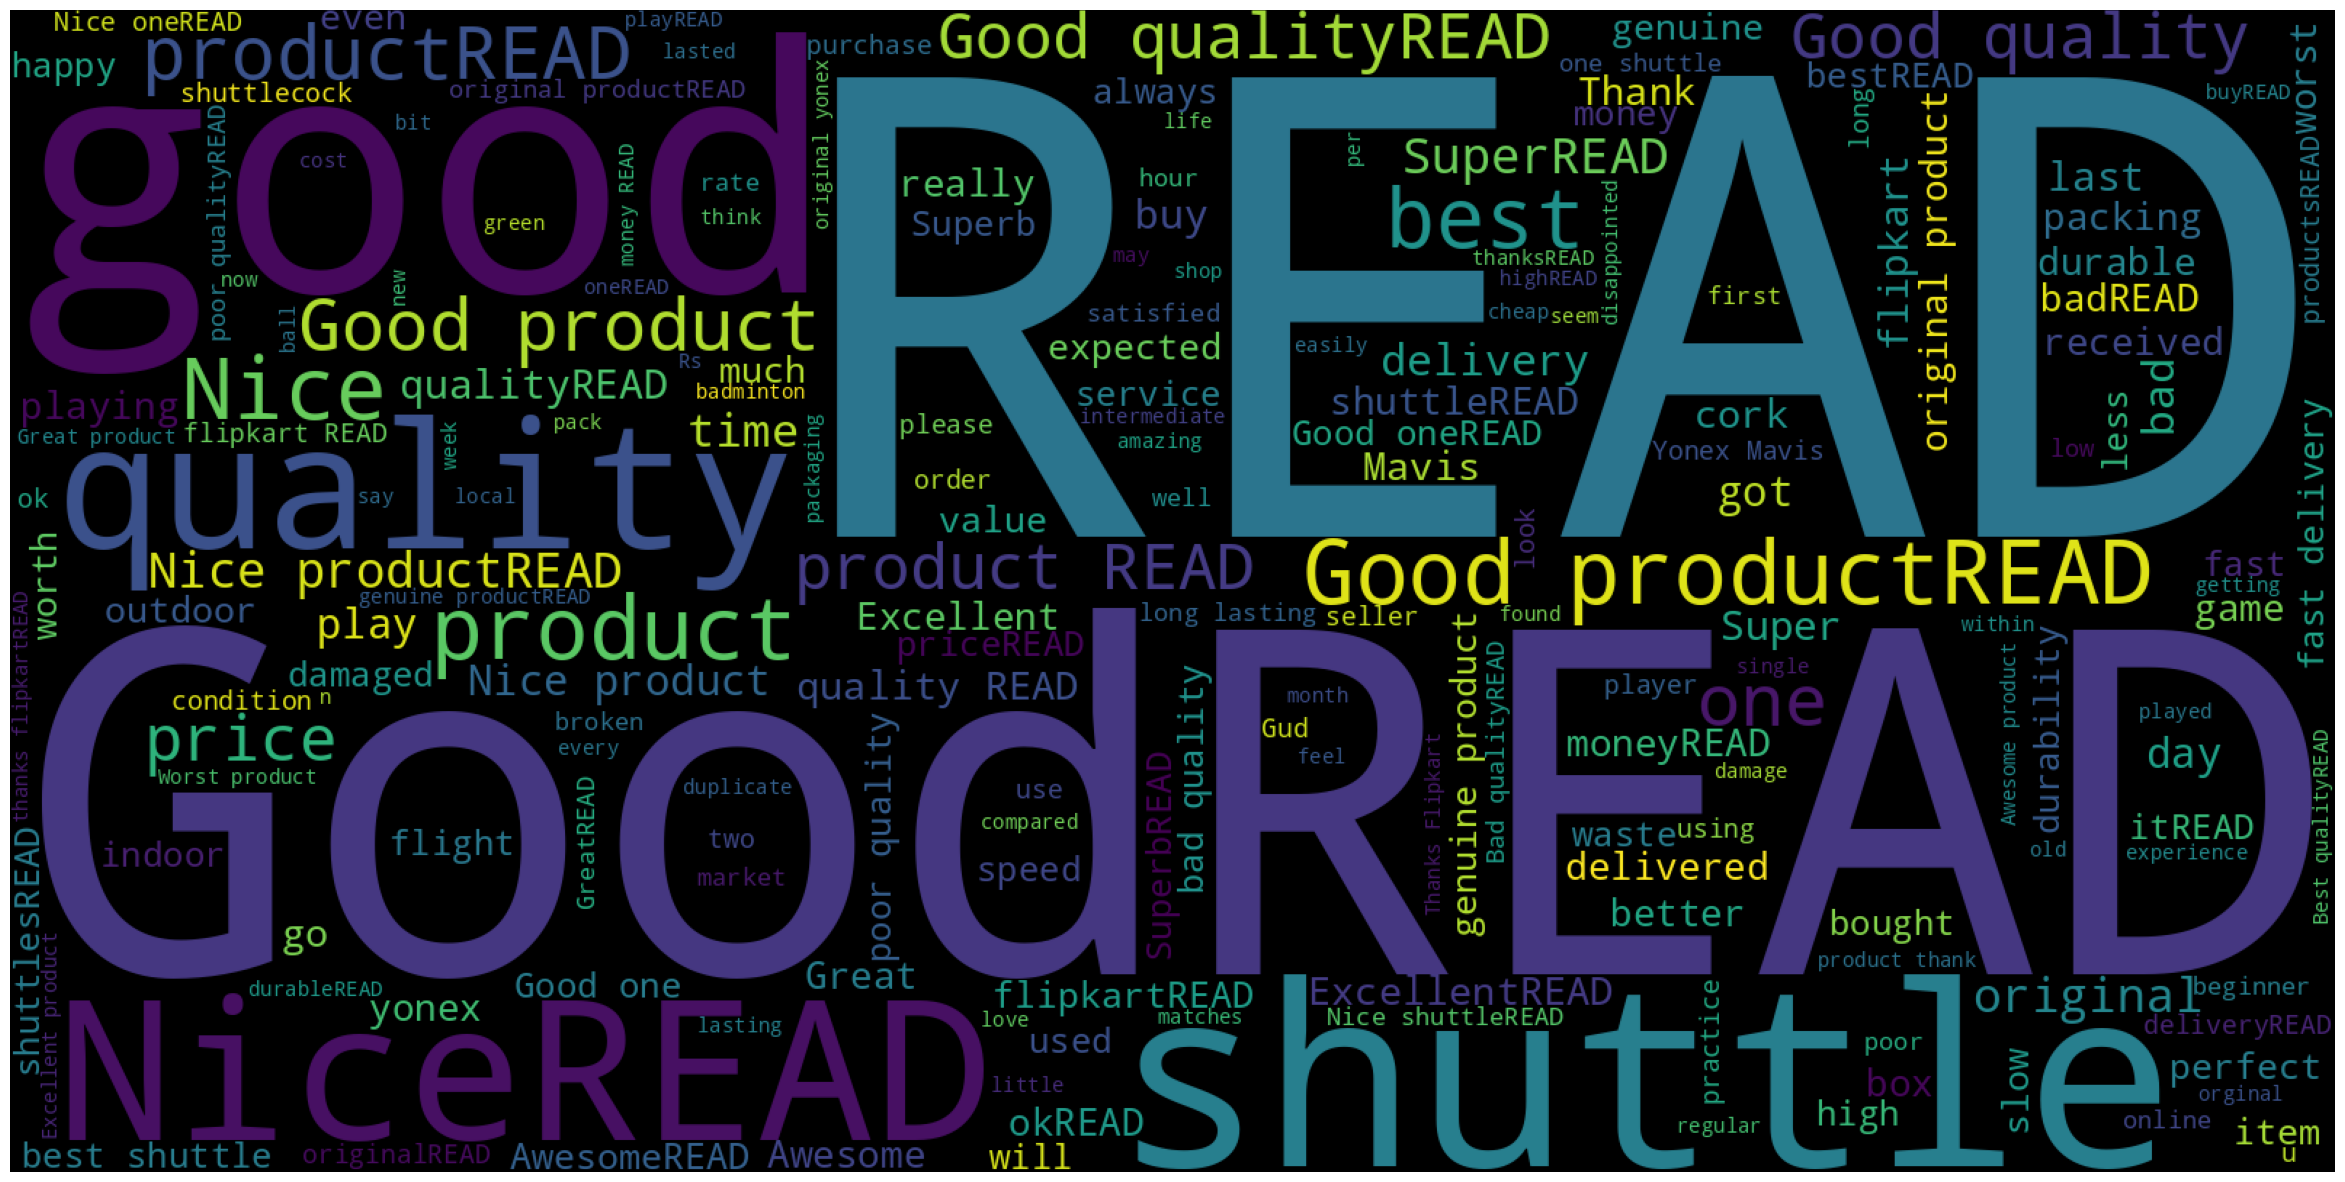

In [6]:
from wordcloud import WordCloud

# Remove NaN values and convert to string
reviews_text = badminton['Review text'].fillna('').astype(str)

# Generate word cloud
wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(reviews_text))

# Display the word cloud
plt.figure(1, figsize=(30, 20))
plt.imshow(wc)
plt.axis('off')
plt.show()


In [7]:
# Check number of null values in 'Review Title' column
null_count = badminton['Review text'].isnull().sum()

print("Number of null values in 'Review Title' column:", null_count)


Number of null values in 'Review Title' column: 8


In [8]:
# Remove rows with null values in 'Review Text' column
badminton = badminton.dropna(subset=['Review text'])

# Verify the changes
print("Shape of DataFrame after removing rows with null values in 'Review Text' column:", badminton.shape)


Shape of DataFrame after removing rows with null values in 'Review Text' column: (8510, 8)


In [9]:
# Define a mapping dictionary for ratings
rating_mapping = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1}

# Map the 'Rating' column using the mapping dictionary
badminton['Ratings'] = badminton['Ratings'].map(rating_mapping)

badminton.shape

<ipython-input-9-6cc19f8006bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  badminton['Ratings'] = badminton['Ratings'].map(rating_mapping)


(8510, 8)

In [10]:
y = badminton["Ratings"]
X = badminton['Review text']
print(X.shape, y.shape)

(8510,) (8510,)


In [11]:
from sklearn.model_selection import train_test_split

# split X and y into training and testing sets.
# By default, it splits 75% training and 25% test
# random_state=1 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6382,) (6382,)
(2128,) (2128,)


In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def display_wordcloud(data):
    wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(data))
    plt.figure(1,figsize=(30,20))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

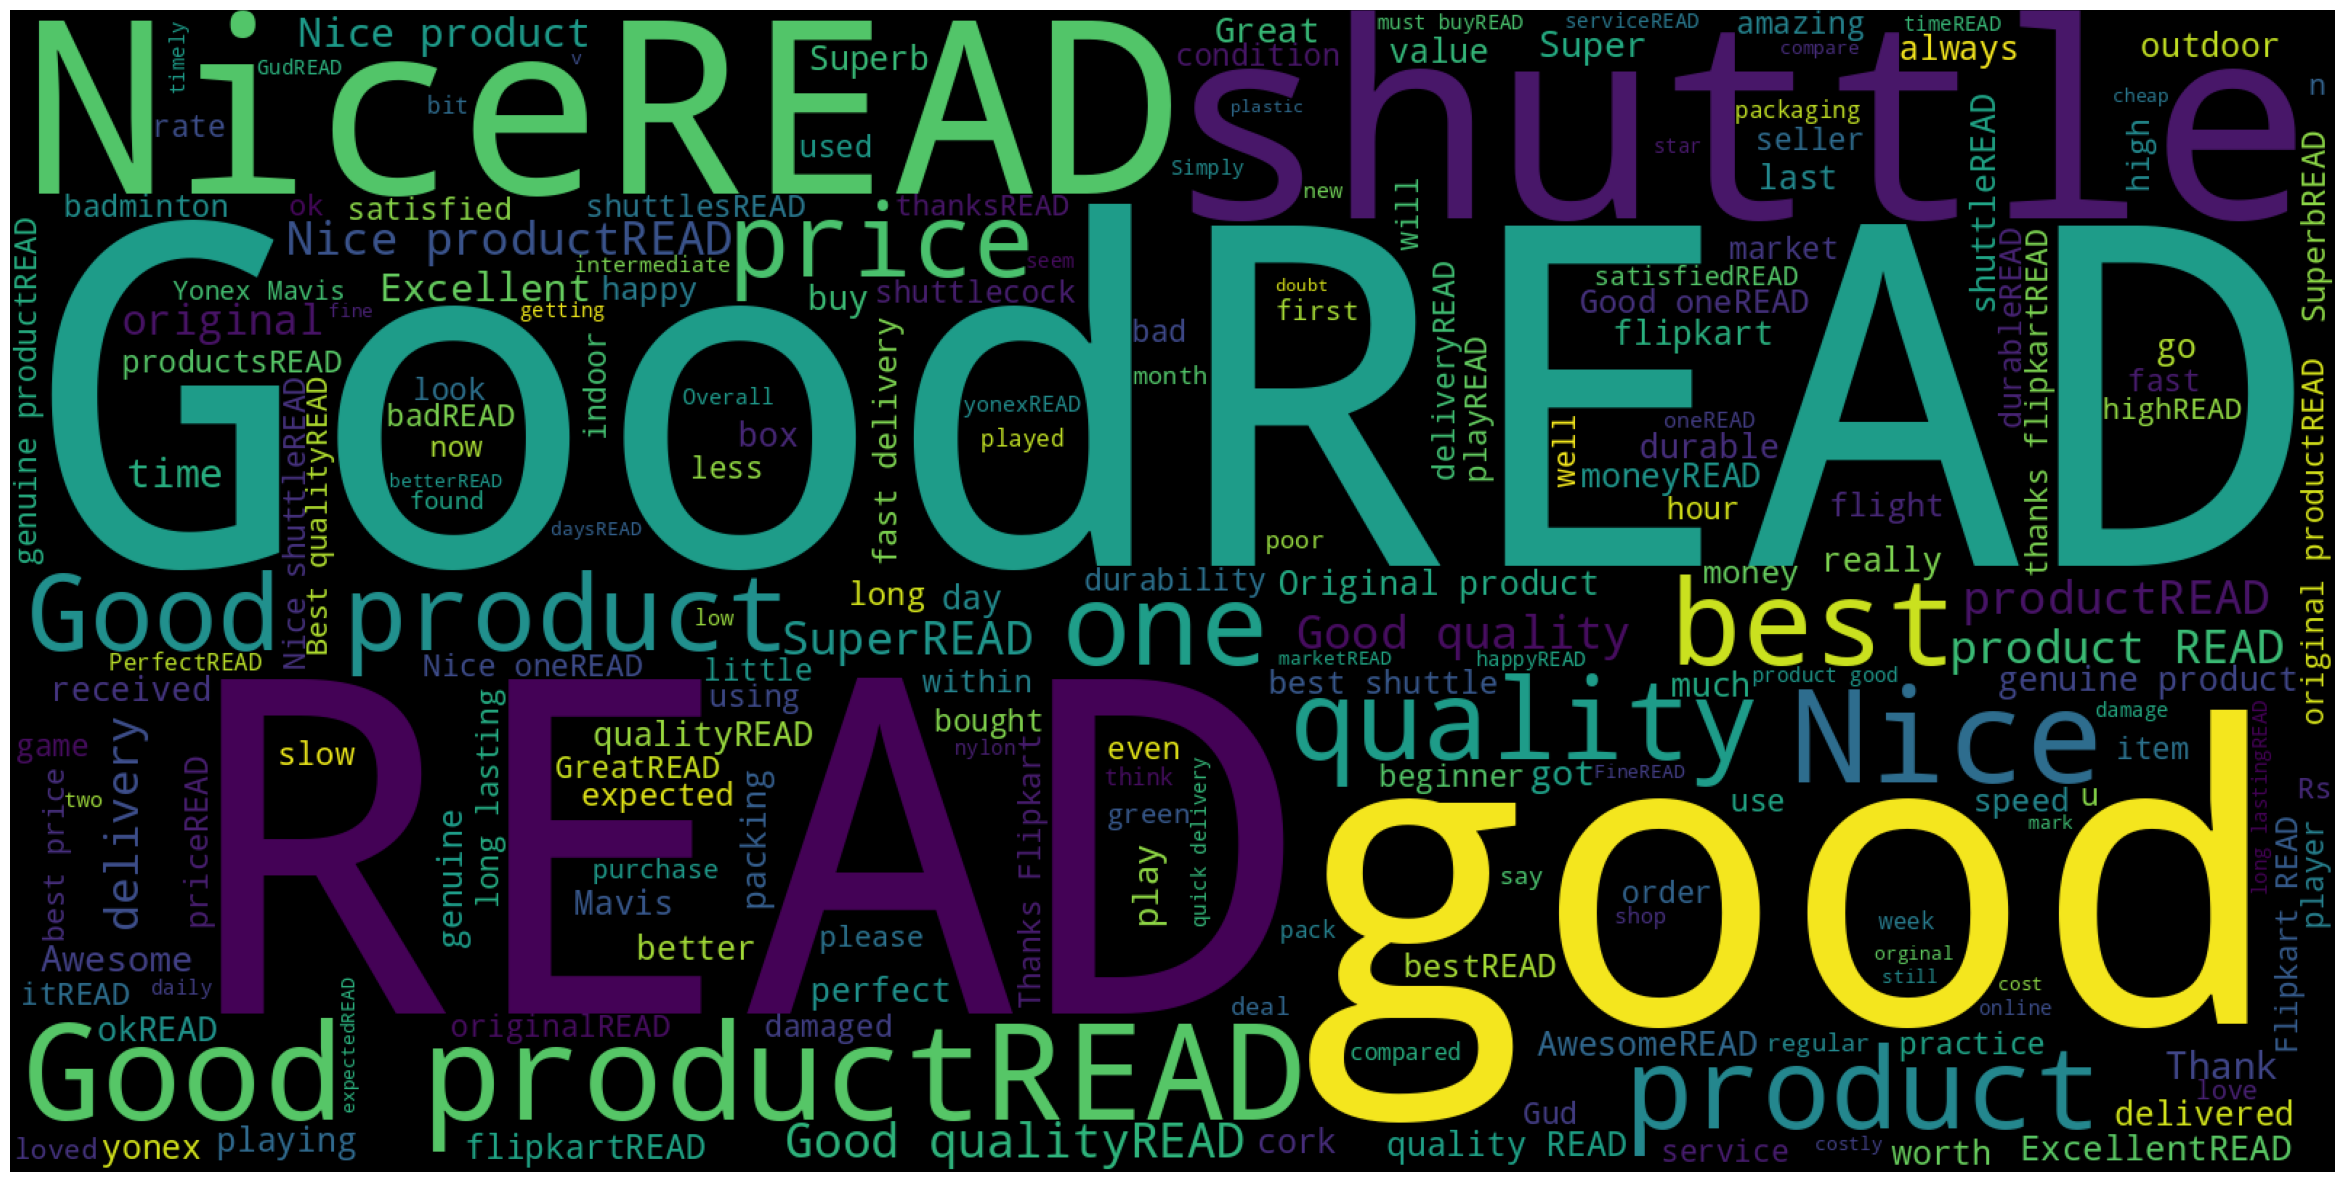

In [13]:
display_wordcloud(X_train[y_train==1])

In [14]:
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:

nltk.download('stopwords')

nltk.download('punkt')

# Function for text preprocessing (cleaning, normalization, and feature extraction)
def clean(text):
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove punctuation and numbers.
    doc = "".join([char for char in text if char not in string.punctuation and not char.isdigit()])
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]

    # Join and return
    return " ".join(filtered_tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

CPU times: user 2.32 s, sys: 125 ms, total: 2.45 s
Wall time: 2.47 s
(6382, 3022)


In [18]:
# Step 4: Data Preprocessing on test data (X_test)

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(2128, 3022)


#Naïve Bayes

In [19]:
# Step 5: Building a Model (i.e. Train the classifier)

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: user 3.22 ms, sys: 26 µs, total: 3.25 ms
Wall time: 3.31 ms


MultinomialNB()

In [20]:
X_train_dtm

<6382x3022 sparse matrix of type '<class 'numpy.int64'>'
	with 21781 stored elements in Compressed Sparse Row format>

In [21]:
# Step 6: Evaluate on train data

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.accuracy_score(y_train, y_train_pred)

0.9360701974302726

In [22]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[ 504,  313],
       [  95, 5470]])

Text(0.5, 23.52222222222222, 'Predicted')

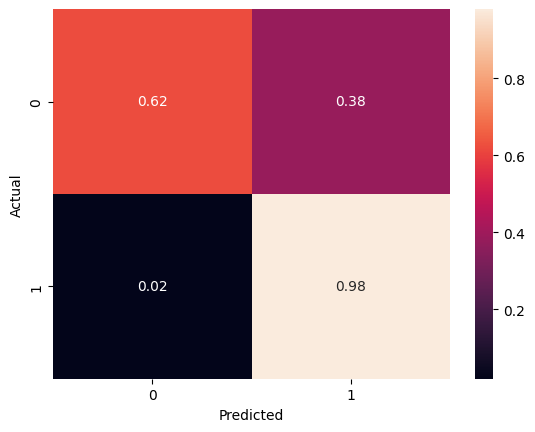

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [24]:
# Step 7: Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_test_pred)

0.9172932330827067

Text(0.5, 23.52222222222222, 'Predicted')

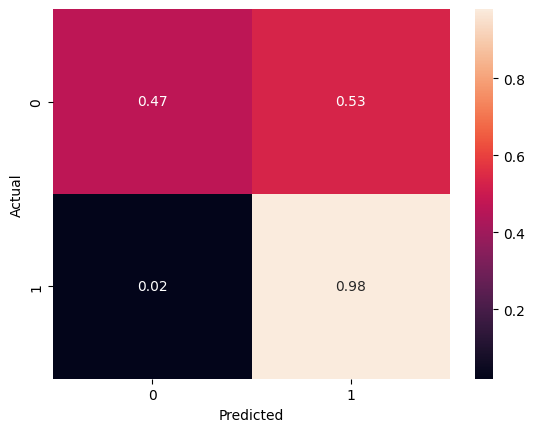

In [25]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [26]:
# # Understand that accuracy is influenced in the presence of data imbalance
# # Let's change the metric to F1 Score

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred))

Train Score (F1 Score): 0.9640465280225591
Test Score (F1 Score): 0.9541666666666667


In [27]:
# Define a function to preprocess the input text
def preprocess_input(text):
    cleaned_text = clean(text)  # Use the clean function defined earlier for preprocessing
    return cleaned_text

# Example input text
new_input = "This badminton racket is bad! I hate the quality and performance."

# Preprocess the input text
preprocessed_input = preprocess_input(new_input)

# Vectorize the preprocessed input text using the trained CountVectorizer
new_input_dtm = vect.transform([preprocessed_input])

# Predict the output using the trained classifier
predicted_output = nb.predict(new_input_dtm)

# Print the predicted output
print("Predicted Rating:", predicted_output[0])


Predicted Rating: 0


In [28]:
import pickle
from google.colab import files

# Save the model to a .pkl file
with open('naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(nb, file)

# Download the .pkl file
files.download('naive_bayes_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Decision_tree

In [29]:
import pickle

# Fit the vectorizer to training data
X_train_dtm = vect.fit_transform(X_train)

# Save the fitted vectorizer to a file
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vect, file)

# Train your model (in your case, Naive Bayes)
nb.fit(X_train_dtm, y_train)

# Save the trained model to a .pkl file
with open('naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(nb, file)


In [30]:
#Building a Model (i.e. Train the classifier)

# import classifiers from sklearn
from sklearn.tree import DecisionTreeClassifier

# Instantiate Decision Tree classifier
decision_tree = DecisionTreeClassifier()

# Train the Decision Tree classifier
decision_tree.fit(X_train_dtm, y_train)


DecisionTreeClassifier()

In [31]:
y_train_pred_dt = decision_tree.predict(X_train_dtm)

train_accuracy_dt = metrics.accuracy_score(y_train, y_train_pred_dt)
print("Train Accuracy (Decision Tree):", train_accuracy_dt)


Train Accuracy (Decision Tree): 0.9801002820432466


In [32]:
metrics.confusion_matrix(y_train, y_train_pred_dt)

array([[ 726,   91],
       [  36, 5529]])

Text(0.5, 23.52222222222222, 'Predicted')

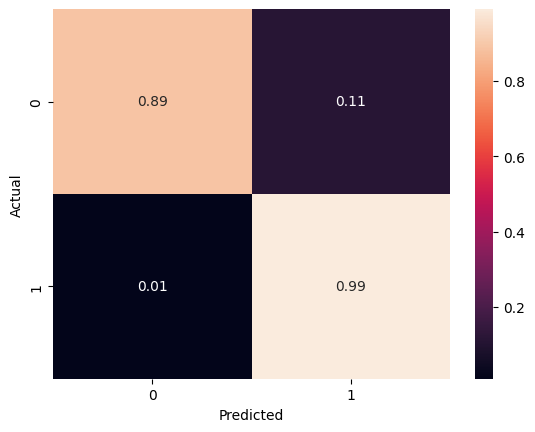

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred_dt)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=decision_tree.classes_, yticklabels=decision_tree.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [34]:
# Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred_dt = decision_tree.predict(X_test_dtm)

test_accuracy_dt = metrics.accuracy_score(y_test, y_test_pred_dt)
print("Test Accuracy (Decision Tree):", test_accuracy_dt)

Test Accuracy (Decision Tree): 0.9060150375939849


Text(0.5, 23.52222222222222, 'Predicted')

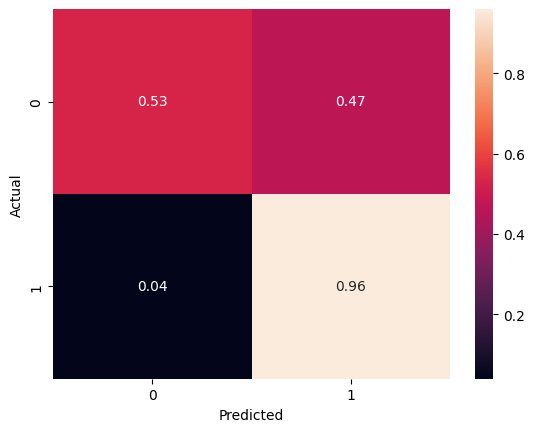

In [35]:
cm = metrics.confusion_matrix(y_test, y_test_pred_dt)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=decision_tree.classes_, yticklabels=decision_tree.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [36]:
print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred_dt))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred_dt))

Train Score (F1 Score): 0.9886455073759498
Test Score (F1 Score): 0.9471458773784355


In [37]:
import pickle

# Fit the vectorizer to training data
X_train_dtm = vect.fit_transform(X_train)

# Save the fitted vectorizer to a file
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vect, file)

# Train your model (in your case, Naive Bayes)
decision_tree.fit(X_train_dtm, y_train)

# Save the trained model to a .pkl file
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(nb, file)


#logistic Regression

In [38]:
# import classifiers from sklearn
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression classifier
logistic_regression = LogisticRegression()

# Train the Logistic Regression classifier
logistic_regression.fit(X_train_dtm, y_train)

# Step 6: Evaluate on train data

# make class predictions for X_train_dtm
y_train_pred_lr = logistic_regression.predict(X_train_dtm)

train_accuracy_lr = metrics.accuracy_score(y_train, y_train_pred_lr)
print("Train Accuracy (Logistic Regression):", train_accuracy_lr)

Train Accuracy (Logistic Regression): 0.9476653086806643


In [39]:
# Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred_lr = logistic_regression.predict(X_test_dtm)

test_accuracy_lr = metrics.accuracy_score(y_test, y_test_pred_lr)
print("Test Accuracy (Logistic Regression):", test_accuracy_lr)

Test Accuracy (Logistic Regression): 0.9191729323308271


In [40]:
metrics.confusion_matrix(y_train, y_train_pred_lr)

array([[ 523,  294],
       [  40, 5525]])

Text(0.5, 23.52222222222222, 'Predicted')

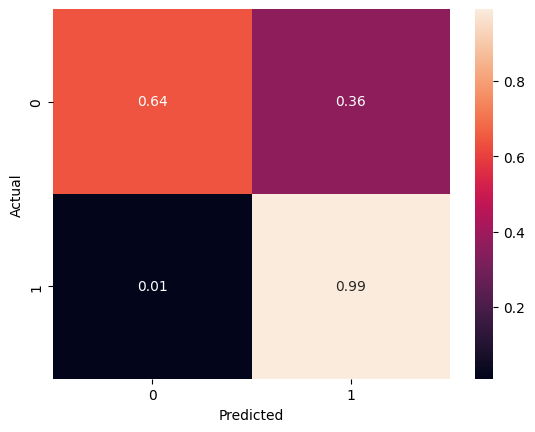

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred_lr)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=logistic_regression.classes_, yticklabels=logistic_regression.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 23.52222222222222, 'Predicted')

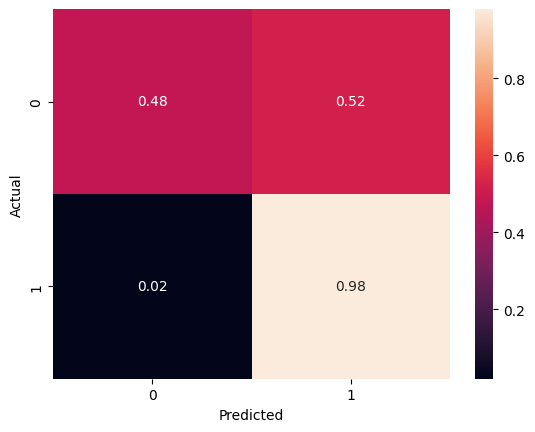

In [42]:
cm = metrics.confusion_matrix(y_test, y_test_pred_lr)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=logistic_regression.classes_, yticklabels=logistic_regression.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [43]:
print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred_lr))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred_lr))

Train Score (F1 Score): 0.9706605762473648
Test Score (F1 Score): 0.9552083333333332


In [44]:
import pickle

# Fit the vectorizer to training data
X_train_dtm = vect.fit_transform(X_train)

# Save the fitted vectorizer to a file
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vect, file)

# Train your model (in your case, Naive Bayes)
logistic_regression.fit(X_train_dtm, y_train)

# Save the trained model to a .pkl file
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(nb, file)
